# Simple tool for creating a monthly public transportation analysis

This notebook takes hourly transportation data taken from IBB open data portal and transforms it into a graphs that shows relative passenger traffic in that district for the period. 

In [2]:
import pandas as pd
import sqlite3 as sq
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Source csv file from IBB open data portal (string)
csv_source = "hourly_transportation_202402.csv"

# SQL DB file to be
sql_db = "202402.db"

# Month of the file that will be appended to the db file as a table (string)
month = "feb"

In [10]:
df = pd.read_csv(csv_source)


In [11]:
# SQL CONNECTION
conn = sq.connect(sql_db)
cursor = conn.cursor()

In [12]:
df.to_sql(month, conn, index=False, if_exists='replace')

16360672

### Main SQL query

This query takes the town names, groups transition hours into 5 and average of the passengers in that transition period for the respective town. Time period order is for ordering time periods for the visuals to make more sense.

In [14]:
query_main = """
SELECT 
    town,
    CASE
        WHEN transition_hour BETWEEN 5 AND 9 THEN 'Morning Rush (5-9)'
        WHEN transition_hour BETWEEN 10 AND 15 THEN 'Daytime (10-15)'
        WHEN transition_hour BETWEEN 16 AND 20 THEN 'Evening Rush (16-20)'
        WHEN transition_hour BETWEEN 21 AND 23 THEN 'Nightlife (21-23)'
        ELSE 'Late Night (0-4)'
    END AS time_period,
    AVG(number_of_passenger) AS nop
FROM 
    feb 

GROUP BY
    town,
    CASE time_period
        WHEN 'Morning Rush (5-9)' THEN 1
        WHEN 'Daytime (10-15)' THEN 2
        WHEN 'Evening Rush (16-20)' THEN 3
        WHEN 'Nightlife (21-23)' THEN 4
        ELSE 5
    END


"""

time_period_order = [
    'Late Night (0-4)',
    'Morning Rush (5-9)',
    'Daytime (10-15)',
    'Evening Rush (16-20)',
    'Nightlife (21-23)'
]
result_main = pd.read_sql(query_main, conn)
result_main['time_period'] = pd.Categorical(
    result_main['time_period'],
    categories=time_period_order,
    ordered=True
)

### Visuals

#### Heatmap

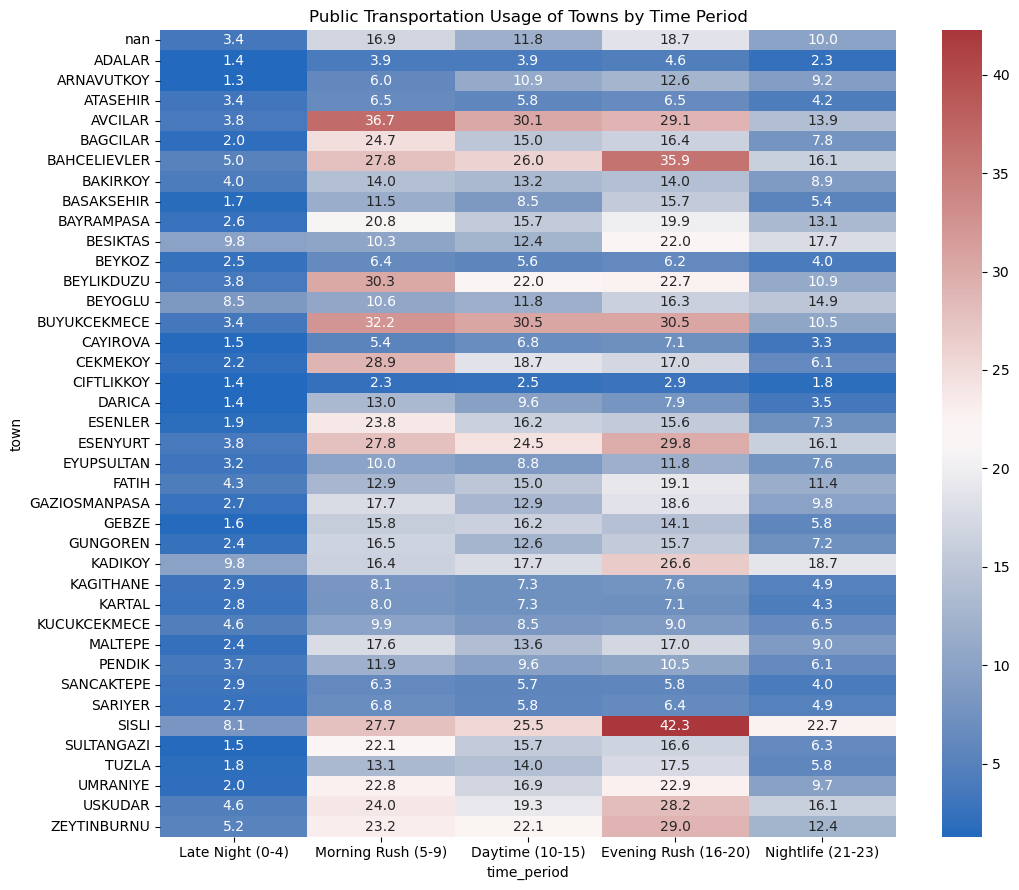

In [15]:
pivot_df = result_main.pivot(index="town", columns="time_period", values="nop")
plt.figure(figsize=(11, 9))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="vlag")
plt.title("Public Transportation Usage of Towns by Time Period")
plt.tight_layout()
plt.show()

In [18]:
conn.close()

# Comparing Transportation traffic of a town for 5 years


This part will compare 5 years of transportation usage for 1 district. The filtering of data happens in the SQL query. 

In [3]:
# Making a df that will include all 5 years of data for the month of february
csv2020 = "hourly_transportation_202002.csv"
csv2021 = "hourly_transportation_202102.csv"
csv2022 = "hourly_transportation_202202.csv"
csv2023 = "hourly_transportation_202302.csv"
csv2024 = "hourly_transportation_202402.csv"
df2020 = pd.read_csv(csv2020)
df2021 = pd.read_csv(csv2021)
df2022 = pd.read_csv(csv2022)
df2023 = pd.read_csv(csv2023)
df2024 = pd.read_csv(csv2024)
# ^ I just didn't wanted to use any code here  just to run 1 concat command. Its bad code but Im just being lazy here.

df_total = pd.concat([df2020, df2021, df2022, df2023, df2024])

febsql_db = "febsql_db.db"
con_t = sq.connect(febsql_db)
cur_t = con_t.cursor()

df_total.to_sql('february', con_t, index=False, if_exists='replace')

58871433

In [9]:
query_total = """
SELECT 
    town,
    CASE
        WHEN transition_hour BETWEEN 5 AND 9 THEN 'Morning Rush (5-9)'
        WHEN transition_hour BETWEEN 10 AND 15 THEN 'Daytime (10-15)'
        WHEN transition_hour BETWEEN 16 AND 20 THEN 'Evening Rush (16-20)'
        WHEN transition_hour BETWEEN 21 AND 23 THEN 'Nightlife (21-23)'
        ELSE 'Late Night (0-4)'
    END AS time_period,
    AVG(number_of_passenger) AS nop,
    transition_date
FROM 
    february
WHERE
    town = 'SISLI'

GROUP BY
    town,
    transition_date,
    CASE time_period
        WHEN 'Morning Rush (5-9)' THEN 1
        WHEN 'Daytime (10-15)' THEN 2
        WHEN 'Evening Rush (16-20)' THEN 3
        WHEN 'Nightlife (21-23)' THEN 4
        ELSE 5
    END


"""



In [10]:
time_period_order = [
    'Late Night (0-4)',
    'Morning Rush (5-9)',
    'Daytime (10-15)',
    'Evening Rush (16-20)',
    'Nightlife (21-23)'
]

In [11]:
result_total = pd.read_sql(query_total, con_t)
result_total['time_period'] = pd.Categorical(
    result_total['time_period'],
    categories=time_period_order,
    ordered=True
)

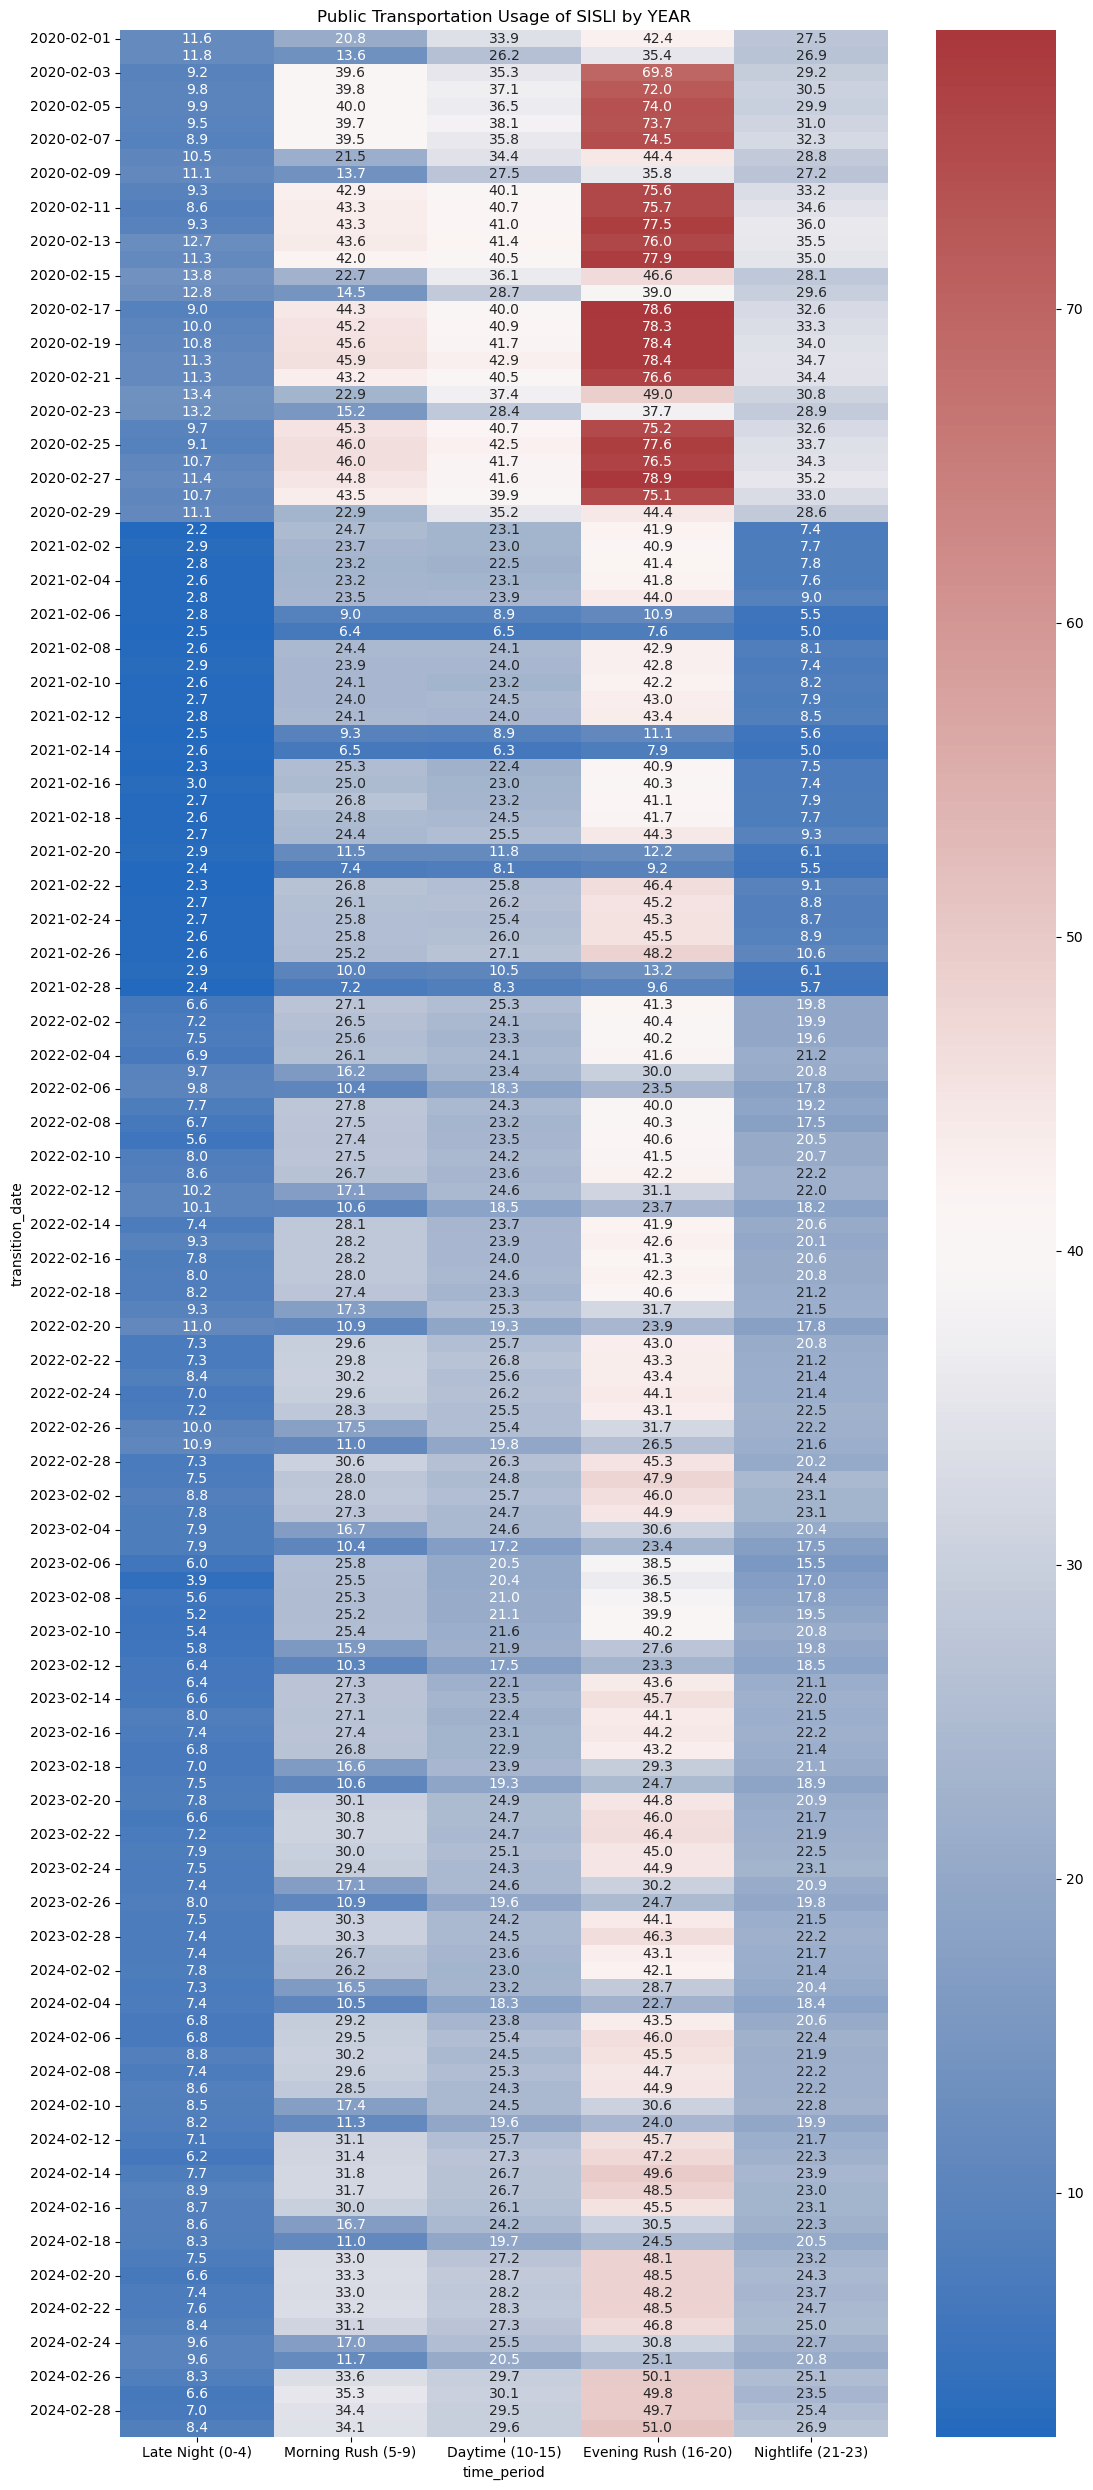

In [14]:
total_df = result_total.pivot(index="transition_date", columns="time_period", values="nop")
plt.figure(figsize=(11, 25))
sns.heatmap(total_df, annot=True, fmt=".1f", cmap="vlag")
plt.title("Public Transportation Usage of SISLI by YEAR")
plt.tight_layout()
plt.show()

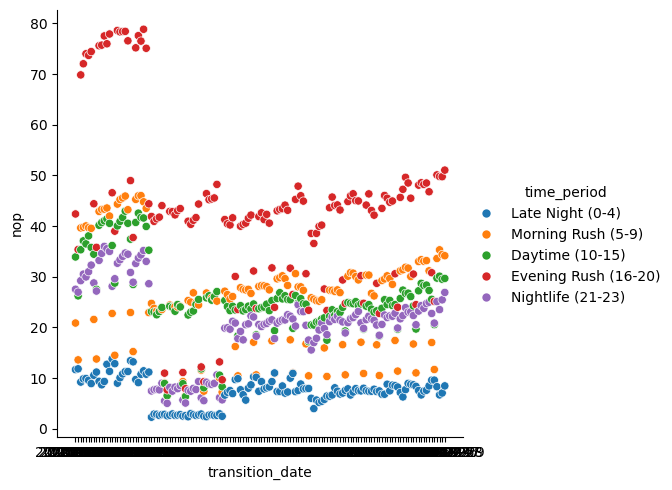

In [17]:
sns.relplot(data=result_total, x="transition_date", y="nop", hue="time_period")



izuta-k.github.io